# PPE analysis template
- Daniel Kennedy (djk2120@ucar.edu)
- updated April 27, 2022
- note that there are dependencies to other files in the repo

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

In [2]:
### import some analysis functions we wrote for this project
###  note that you can inspect the code for these functions in ../ppe_tools/analysis.py
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### optional: set up your PBSCluster
- not necessary if you are working with preprocessed data
- client.cluster will show when your workers are active
- note it can take a few minutes to get through the job queue
- set up to ask for 1hr, but can be increased

In [3]:
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [4]:
## wait until workers >0
client.cluster

### Get some info about the ensemble

In [6]:
csv = '/glade/campaign/asp/djk2120/PPEn11/csvs/SP_ensemble.csv' #basically a list of good simulations
#csv = '/glade/campaign/asp/djk2120/PPEn11/csvs/surv.csv'  #BGC
ds0,la,lapft,attrs,paramkey,keys = ppe_init(csv=csv)       

#ds0 is a dummy empty dataset, that can be useful to have around
#la = landarea
#lapft = pft patch areas
#attrs = some conversion factors I like to have around
#paramkey/keys = backend stuff

### load an ensemble to ds

In [7]:
data_vars = ['FPSN','EFLX_LH_TOT']
ensemble = 'CTL2010SP'
htape = 'h0'
ds = get_ensemble(data_vars,ensemble,htape,csv=csv)

# can examine get_ensemble in ../ppe_analysis/analysis.py


#h0 = monthly, h1 = pft, h5=daily
#BGC ensembles
#  CTL2010 - 2010 climate, CO2=367ppmv
#  AF1855  - 1855 climate, CO2=367ppmv
#  AF2095  - 2095 climate, CO2=367ppmv
#  C285    - 2010 climate, CO2=285ppmv
#  C867    - 2010 climate, CO2=867ppmv
#  NDEP    - 2010 climate, CO2=367ppmv, NDEP+=5g/m2

In [8]:
### here's the set of netcdf files, if useful
files = get_files('CTL2010SP','h0',keys)

In [12]:
ds.FPSN

<xarray.DataArray 'FPSN' (ens: 229, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(229, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 221 222 223 224 225 226 227 228
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    long_name:     photosynthesis
    units:         umol m-2 s-1
    cell_methods:  time: mean

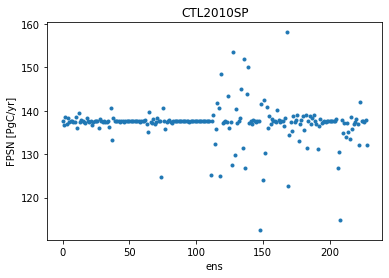

In [20]:

cf1  = 24*60*60  #s->d   d->yr is internal to ann_mean
cf2  = 12e-15    #molC->PgC  (umol->mol cancels km2->m2 from la)

unit = 'PgC/yr'

v = 'FPSN'
xann  = ann_mean(ds[v],cf1).mean(dim='year')
xglob = reg_mean(xann,la,cf=cf2)
xglob.name = v
xglob.attrs = {'units':unit}
xglob.plot.line('.')
plt.title(ensemble);


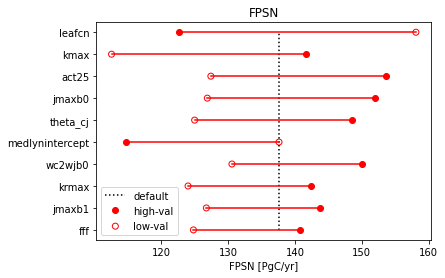

In [21]:
rank_plot(xglob,ds0,10)

In [22]:
##access the top_n without plotting
da = xglob
nx = 10
xmins,xmaxs,pvals=top_n(da,nx,ds0.param,ds0.minmax)
pvals[-1::-1]  #list is in reverse order

['leafcn',
 'kmax',
 'act25',
 'jmaxb0',
 'theta_cj',
 'medlynintercept',
 'wc2wjb0',
 'krmax',
 'jmaxb1',
 'fff']

### examine GPP, one ensemble member

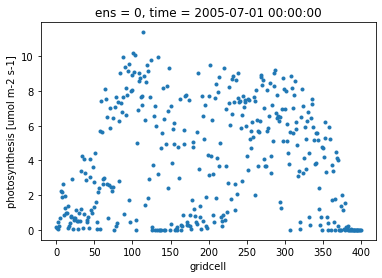

In [23]:
## note that the output is not global, but rather a subset of 400 meaningful pixels
##   so you can't plot a map directly
ds.FPSN.isel(ens=0,time=6).plot.line('.');    #ens0 = default

In [21]:
help(get_map)

Help on function get_map in module ppe_tools.analysis:

get_map(da)
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...



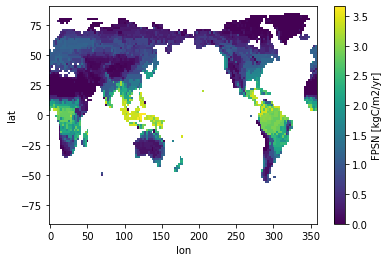

In [26]:
#slow, but should work...
cf = 12/1e9
da_map=cf*get_map(xann.isel(ens=0))
da_map.name = v
da_map.attrs = {'units':'kgC/m2/yr'}
da_map.plot();

In [27]:
## the perturbations are described via ds.param, ds.minmax
for i in range(10):
    print(ds.param.sel(ens=i).values,ds.minmax.sel(ens=i).values )

default default
taulnir min
taulnir max
taulvis min
taulvis max
tausnir min
tausnir max
tausvis min
tausvis max
rholnir min


### look at a single gridcell

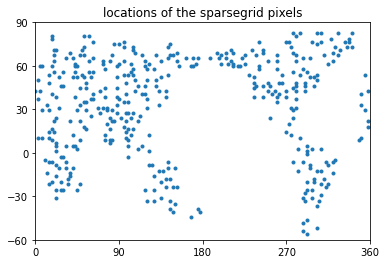

In [28]:
plt.plot(ds.grid1d_lon,ds.grid1d_lat,'.')
plt.xlim([0,360]); plt.xticks(90*np.arange(5))
plt.ylim([-60,90]); plt.yticks(-60+30*np.arange(6))
plt.title('locations of the sparsegrid pixels');

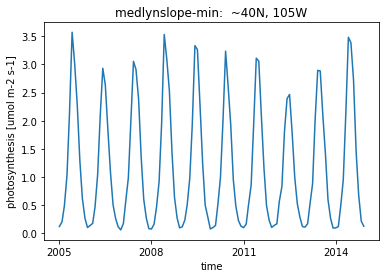

In [33]:
lat  = 40
lonw = 105
lon  = 360-lonw  #105W

#find nearest point
d = np.sqrt((ds.grid1d_lat-lat)**2+(ds.grid1d_lon-lon)**2)
ix = d==np.min(d)
   
#pick an ensemble member and plot
ee = 205
ds.FPSN.isel(ens=ee,gridcell=ix).plot()

p = str(ds.param.isel(ens=ee).values)
m = str(ds.minmax.isel(ens=ee).values)
plt.title(p+'-'+m+':  ~'+str(lat)+'N, '+str(lonw)+'W');
    

In [46]:
#approx conus sparsegrid samples
ix=(ds.grid1d_lat>=27)&(ds.grid1d_lat<=49)&(ds.grid1d_lon>=200)&(ds.grid1d_lon<=295)
ix.sum()

<xarray.DataArray ()>
array(29)

### Examine param perturbation values

In [47]:
## if you want to examine the actual values of a given param
param = 'jmaxb1'

## shouldn't need to edit below

ix = ds.param==param
params = ['default',*ds.param.isel(ens=ix).values]
minmax = ['default',*ds.minmax.isel(ens=ix).values]

ix = ds.ens>np.inf
for p,m in zip(params,minmax):
    ix = (ix)|((ds.param==p)&(ds.minmax==m))

keys = ds.key.isel(ens=ix).values
pvals = []
pdir = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
lndin = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
for key,p in zip(keys,params):
    pf = xr.open_dataset(pdir+key+'.nc')
    if param in pf.data_vars:
        pvals.append(pf[param].values)
    else:
        nfile = ndir+key+'.txt'
        if p=='default':
            cmd = 'grep '+param+' '+lndin
            tmp = os.popen(cmd).read().split()[2]
            if 'd' in tmp:
                tmp = tmp.split('d')
                pval = float(tmp[0])*10**float(tmp[1])
            else:
                pval = float(tmp)
        else:
            with open(nfile) as f:
                lines = f.readlines()
                pval = float(lines[1].split('=')[1].split('\n')[0])
        pvals.append(pval)
### note that default may also serve as min or max
for i,m in enumerate(minmax):
    print(param,m,pvals[i])

jmaxb1 default 0.17
jmaxb1 min 0.05
jmaxb1 max 0.25


### examine a sample file
- useful for checking which variables are available

In [48]:
h0 = get_files('CTL2010SP','h0',['OAAT0000'])[0]
ds0 = xr.open_dataset(h0)
ds0.data_vars

Data variables: (12/276)
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    ...                                 ...
    Vcmx25Z                            (time, gridcell) float32 ...
    WASTEHEAT                          (time, gridcell) float32 ...
    WIND                               (time, gridcell) float32 ...
    ZBOT                               (time, gridcell) float32 ...
    ZWT                                (time, gridcell) float32 ...
    ZWT_PERCH                          (time, gridcell) float32 ...

In [49]:
h5 = get_files('CTL2010SP','h5',['OAAT0000'])[0]
ds5 = xr.open_dataset(h5)
ds5.data_vars

Data variables: (12/56)
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ...
    mscur               (time) int32 ...
    nstep               (time) int32 ...
    time_bounds         (time, hist_interval) object ...
    ...                  ...
    EFLX_LH_TOT         (time, gridcell) float32 ...
    FPSN                (time, gridcell) float32 ...
    FSH                 (time, gridcell) float32 ...
    RH2M                (time, gridcell) float32 ...
    TSA                 (time, gridcell) float32 ...
    TSKIN               (time, gridcell) float32 ...